# Testing an 'online' estimator for $R_n$

### Imports

In [102]:
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

### Noise Generator $N_t$
A core assumption of the SPS algorithm is that the noise is zero mean, symmetric and iid

# ARMAX Generator
Class for simulating a system of the form $A(q)y(t) = B(q)u(t) + C(q)e(t) + D$

This class has been developed with the intention of running it in 'online' mode where an update function will be called at each cycle

In [103]:
class ARMAX_Generator:
    def __init__(self, A: list, B: list, C: list, D: list, input_controller) -> None:
        # System Parameters
        self.A = A  # AR coefficients
        self.B = B  # X input coefficients
        self.C = C  # MA coefficients
        self.D = D  # Constant term

        self.order = max(len(A), len(B), len(C))
        self.t = 0

        # TODO delete this
        def temp_input_controller(y, u) -> float: 
            sigma = 0.1
            return 0.4 * y[-1] + np.random.normal(sigma)
        
        self.input_controller = input_controller

        # State
        # The below vectors should all be of the same length equal to the current time step
        self.y = []  # Output of the system
        self.u = []  # Input to the system
        self.e = []  # Noise input to the system

    # TODO Replace this with a user-provided noise function which can be any zero-mean symmetric iid noise source
    def generate_noise(self) -> float:
        sigma = 0.1
        self.e.append(np.random.normal(0, sigma))
    
    # Generate new datapoints for the next timestep and append it to the system's state
    def generate_datapoint(self) -> None: 
        # AR component
        overlap = min(len(self.A)-1, len(self.y)) # Calculate the overlap between A(2), A(3), A(...) and the past inputs
        ar_sum = np.matmul(self.A[1:overlap+1:][::-1], self.y[-overlap::]) # Reverse the order of the coefficients and multiply the matrices

        # Exogenous input component
        overlap = min(len(self.B), len(self.u))
        exo_sum = np.matmul(self.B[:overlap:][::-1], self.u[-overlap::])

        # MA component
        overlap = min(len(self.C), len(self.e))
        ma_sum = np.matmul(self.C[:overlap:][::-1], self.e[-overlap::])

        # Compute output
        self.y.append( -ar_sum + exo_sum + ma_sum + self.D / self.A[0])
        self.u.append( self.input_controller(self.y, self.t) )
        
        # Increment next time index
        self.t += 1

In [122]:
class LqrController:
    def __init__(self) -> None:
        self.is_reuse_noise = True  # Set flag to true if the noise samples should be retained across multiple calculations of output
                                    # This should help with the issue where random noise in the controller output could not be captured when calculating SPS
        self.t = 0
        self.Nt = [] # Vector of noise values

        self.K = 0.5

        self.sigma = 0.0001 # Variance of noise generated

    # Generates t length vector of noise values
    def regenerate_noise(self):
        self.Nt = [ np.random.normal(self.sigma) for x in range(self.t)]

    # TODO: Define the logic for the online controller
    def update_gain(self):
        pass

    # This function can be passed into the ARMAX Generator instance
    def generate_output(self, y_vals: float, t: int) -> np.ndarray:
        noise = 0.0
        prev_y = y_vals[-1]

        if self.is_reuse_noise:
            if len(self.Nt) < t+1:
                raise "Error: noise samples not initialised"
            noise = self.Nt[t]
        else:
            noise = np.random.normal(self.sigma)
            if len(self.Nt) < t:
                self.Nt = np.concatenate([self.Nt, np.zeros(t - len(self.Nt))])
            self.Nt[t] = noise
        
        return self.K * prev_y + noise


In [105]:
# LQR Testing
# controller = LqrController()

# y = [0 for x in range(50)]
# controller.t = len(y)
# controller.is_reuse_noise = False
# # controller.regenerate_noise()

# print(controller.generate_output(y[0], 50))
# print(controller.generate_output(y[0], 50))
# controller.is_reuse_noise = True
# print(controller.generate_output(y[0], 50))


# SPS Algorithm

In [106]:
class SPS:
    def __init__(self, p:float=(1-5/40), m:int=40, q:int=5, n:int=0, T:int=1) -> None:
        self.p = p # Confidence probability
        self.m = m # Integer m such that p = 1 − q/m
        self.q = q # Integer q such that p = 1 − q/m
        self.n = n # Number of data points

        self.T = T # block SPS window size
        self.T_repetitions_left: int = 0
        
        self.alpha = None # Random signs
        self.pi = None    # Random permutation

    # Process one time step
    # This is the main function for the real-time SPS implementation
    def update(self) -> None:
        self.n += 1
        self.append_alpha_column()
        self.generate_random_perm()

    # Generate a column of alpha values
    # This should be called whenever we add another data sample (n -> n+1)
    def append_alpha_column(self) -> None:
        new_col = None

        if self.T > 1 and self.T_repetitions_left > 0:
            self.T_repetitions_left -= 1 # Decrement repetitions

            # Repeat the last column in the array
            new_col = self.alpha[:, [-1]]

        else:
            # Check if we need to reset T
            if self.T > 1:
                self.T_repetitions_left = self.T - 1

            # Generate new column of random values
            options = [-1, 1]
            new_col = np.transpose(np.array([[np.random.choice(options) for _ in range(self.m)]]))

        # Update the state of the class instance
        if self.alpha is None:
            self.alpha = new_col
        else:
            self.alpha = np.concatenate([self.alpha, new_col], axis=1)

    # Generates m-by-n matrix of integers for ordering SPS indicators
    # TODO Determine if there's anyway to avoid regenerating old values in the pi matrix. 
    def generate_random_perm(self) -> None:
        self.pi = np.random.permutation(range(self.m-1)) 

    # TODO Test this code
    def least_square_estimator(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        theta_hat = np.linalg.lstsq(np.matmul(np.transpose(X), X), np.matmul(np.transpose(X), y))
        
        return theta_hat
    
    def create_feature_matrix(self, A: np.ndarray, B: np.ndarray, C: np.ndarray, y: np.ndarray, u: np.ndarray) -> np.ndarray:
        N = len(y)
        matrix_length = len(A) - 1 + len(B)
        
        X = np.zeros((N, matrix_length))

        # TODO Check which index we should start on 
        # Should it be the first X with no zero values or t=0
        # I don't think it should matter since a row of all zeros will multiply out to zero in the outer product for Rn
        for t in range(1, N):
            phi = self.get_phi(A, B, C, y, u, t)
            X[t,:] = phi

        return X

    def get_phi(self, A: np.ndarray, B: np.ndarray, C: np.ndarray, y: np.ndarray, u: np.ndarray, t: int) -> np.ndarray:
        # This vector will consist of negative A parameters (except A0) and all B parameters
        # The noise parameter matrix C will be ignored

        num_y_samples = len(A) - 1 # Ignore first A parameter
        num_u_samples = len(B)

        # Calculate how many zeros need to be padded to output
        num_y_zeros = max(num_y_samples - t, 0)
        num_u_zeros = max(num_u_samples - t-1, 0)

        y_temp = y
        u_temp = u

        if num_y_zeros > 0:
            # Pad zeros to the left of the input if necessary
            zeros = num_y_zeros * [0]
            y_temp = np.concatenate([zeros, y])
    
        if num_u_zeros > 0:
            zeros = num_u_zeros * [0]
            u_temp = np.concatenate([zeros, u])        

        phi_y = y_temp[t+num_y_zeros-num_y_samples:t+num_y_zeros][::-1]
        
        # phi_u = u_temp[t:t-num_u_samples:-1]
        phi_u = u_temp[t+num_u_zeros-num_u_samples+1:t+num_u_zeros+1][::-1]

        return np.concatenate([phi_y, phi_u])
    
    def sps_indicator(self,
            y: np.ndarray, # Actual past outputs of the system
            u: np.ndarray, # Actual past inputs of the system
            A_star: np.ndarray, # Test A matrix
            B_star: np.ndarray, # Test B matrix
            C_star: np.ndarray, # Test C matrix
            D_star: int # Constant term
        ) -> bool:
        
        # Since we are using the ARMAX format, we are assuming that the system is closed-loop
        A_yt = self.basic_filter(A_star, y) # Compute A(q)y_t
        B_ut = self.basic_filter(B_star, u) # Compute B(q)u_t

        diff_AB = A_yt - B_ut

        # Reconstruct the noise C^-1(A(q)y_t - B(q)u_t)
        nt_theta = self.filter([1], C_star, diff_AB)
        sp_errors = np.multiply(self.alpha, nt_theta) # Regenerate sign perturbed noise
        
        # Initialise controller
        lqr = LqrController()
        lqr.t = self.n
        lqr.regenerate_noise() # Generate noise samples once for re-use inside this loop
        lqr.is_reuse_noise = True 
        
        S = np.zeros(self.m-1)
        

        # Calculate baseline S0
        X = self.create_feature_matrix(A_star, B_star, C_star, y, u)
        R = np.matmul(np.transpose(X), X) / self.n
        R_root = scipy.linalg.cholesky(R)
        R_inv_root = scipy.linalg.inv(R_root)
        
        S[0] =  scipy.linalg.norm( np.matmul( R_inv_root, np.matmul(np.transpose(X), nt_theta) / self.n ))
        
        
        # Calculate SPS 
        for i in range(1, self.m - 1):
            armax_bar = ARMAX_Generator(A_star, B_star, C_star, D_star, lqr.generate_output)
            # Set the noise for the armax generator
            armax_bar.e = sp_errors[i,:]
            
            # Generate the ARMAX data
            for _ in range(self.n):
                armax_bar.generate_datapoint()

            X_bar = self.create_feature_matrix(A_star, B_star, C_star, armax_bar.y, armax_bar.u)
            R_bar = np.matmul(np.transpose(X_bar), X_bar) / self.n
            R_bar_inv_root = scipy.linalg.inv(scipy.linalg.cholesky(R_bar))
            temp = np.matmul(np.transpose(X_bar), np.transpose(sp_errors[i,:])) / self.n
            temp = np.matmul(R_bar_inv_root, temp)
            S[i] = scipy.linalg.norm( temp )
            
        # Combine S and Pi into a matrix
        SP = np.array([S, self.pi])

        # First sort by 1st col then 0th col
        sort_indices = np.lexsort((SP[1,:], SP[0,:]))
        
        # Check that the SP0 
        return sort_indices[0]  <= self.m - self.q - 1
    


    # FIR Filter where the A matrix is [1]
    def basic_filter(self, B: np.ndarray, X: np.ndarray) -> np.ndarray:
        # return np.convolve(B, X)[:len(X)]
        return scipy.signal.lfilter(B, [1.0], X)
    
    def filter(self, B: np.ndarray, A: np.ndarray, X) -> np.ndarray:
        return scipy.signal.lfilter(B, A, X)


# Testing

In [107]:
# SPS Testing
sps = SPS(p=1-1/8, T=1)

# Actual system parameters
A = [1, 0.5, 0.25]
B = [1,2]
C = [1]

n = 50

# Known Controller
known_controller = LqrController()
known_controller.t = 50
known_controller.regenerate_noise()
known_controller.is_reuse_noise = True

# Generate the real data
armax = ARMAX_Generator(A, B, C, 0, known_controller.generate_output)

# Simulate N datapoint updates in the system
for i in range(n):
    armax.generate_noise()
    armax.generate_datapoint()
    sps.update()

print(armax.y)
print(armax.u)

# Calculate SPS 

S = sps.sps_indicator(armax.y, armax.u, A, B, C, 0)
print(S)



[0.04928223957641421, 0.96834964000017, 1.8974346049801152, 0.2541083620615236, 0.22762526784099343, -1.6117902999761529, -0.19079708019520256, 1.668434956671813, -3.7299146691221874, -1.7904210029385863, -5.551382997693324, -0.3050923152255186, -5.723293629903625, 1.9350881661390635, -5.665506758966668, -0.3764356090724692, -3.8098726467392026, 0.05007617064311275, -9.787011586376103, -5.829708723394592, -7.190847568940224, -4.972934799728815, -7.96155883827248, -6.071143418502068, -6.5056704917812755, -4.349530749353229, -8.02799400382984, -1.3232048065745887, -4.641486600029732, -3.298485821754518, -4.3325660423773416, -2.5827421548286895, -0.41987176741342913, -0.13517284934616752, 0.7105934796974918, 1.6323118431741652, 5.282348082685255, 3.7006089882644098, 3.796391159942019, 1.8252018003815405, -0.01048632281611997, 1.3496794951397582, 0.11284084551712356, -0.5217523604596693, 2.6828899070897974, 3.387759881028867, 3.0934271766948074, 0.17903486925542061, 0.11883902885118013, -1

## Generate the plot

In [120]:
theta_real = [0.44, 0.33, 0]

sps = SPS(p=0.95, T=1, m=100, q=5)

# Actual system parameters
A = [ 1, theta_real[0] ]
B = [ 0, theta_real[1] ]
C = [ 1, theta_real[2] ]

n = 50

# Known Controller
known_controller = LqrController()
known_controller.t = 50
known_controller.regenerate_noise()
known_controller.is_reuse_noise = True

# Generate the real data
armax = ARMAX_Generator(A, B, C, 0, known_controller.generate_output)

# Simulate N datapoint updates in the system
for i in range(n):
    armax.generate_noise()
    armax.generate_datapoint()
    sps.update()

print(armax.y)
print(armax.u)

# Calculate SPS 
a = np.linspace(0.2, 0.8, 20)
b = np.linspace(0.1, 0.5, 20)

confidence_region = []

for test_a in a:
    for test_b in b:
        A_star = [1, -test_a]
        B_star = [0, test_b]
        C_star = [1, 0]
        D_star = 0

        if sps.sps_indicator(armax.y, armax.u, A_star, B_star, C_star, D_star):
            confidence_region.append( (test_a, test_b) )
# S = 
# print(S)

[0.10463007429270038, -0.13017470220725053, 0.3907440008176235, -0.1498674211895677, -0.16181308649202827, -0.04436564650606411, -0.4124722693199905, -0.24671939827408326, 0.22215000784561434, -0.49155494958830537, -0.17665454336684608, 0.23437804161599046, -0.205039483549338, 0.036496262672393545, 0.16293555897051418, 0.1257347548997767, -0.4104139400146898, -0.18961839631906838, 0.7261105189215841, -0.7160562162084335, 0.43636051607346354, -0.15762383176972758, -0.4007787003159786, -0.12138179086901091, 0.06691416630053948, -0.2273634697771011, 0.3144696750612893, 0.16183020044860807, 0.22157254211390676, -0.2452071138027498, 0.3730187460996024, -0.30163318258216526, 0.2793349149649932, -0.3999543464709817, 0.1302235068032087, 0.4776155466998951, 0.10389951882562107, -0.20456507727166556, 0.2563227506242278, -0.6882312173908667, 0.20909821598189487, -0.2596764873301224, 0.1934795109535827, -0.33262130058645994, -0.14671082798103446, -0.025071985000343973, 0.43824604893566454, 0.16066

[(0.2, 0.1), (0.2, 0.12105263157894737), (0.2, 0.14210526315789473), (0.2, 0.1631578947368421), (0.2, 0.1842105263157895), (0.2, 0.20526315789473684), (0.2, 0.22631578947368422), (0.2, 0.24736842105263157), (0.2, 0.26842105263157895), (0.2, 0.2894736842105263), (0.2, 0.31052631578947365), (0.2, 0.3315789473684211), (0.2, 0.3526315789473684), (0.2, 0.37368421052631584), (0.2, 0.39473684210526316), (0.2, 0.4157894736842105), (0.2, 0.4368421052631579), (0.2, 0.45789473684210524), (0.2, 0.4789473684210527), (0.2, 0.5), (0.23157894736842108, 0.1), (0.23157894736842108, 0.12105263157894737), (0.23157894736842108, 0.14210526315789473), (0.23157894736842108, 0.1631578947368421), (0.23157894736842108, 0.1842105263157895), (0.23157894736842108, 0.20526315789473684), (0.23157894736842108, 0.22631578947368422), (0.23157894736842108, 0.24736842105263157), (0.23157894736842108, 0.26842105263157895), (0.23157894736842108, 0.2894736842105263), (0.23157894736842108, 0.31052631578947365), (0.23157894736

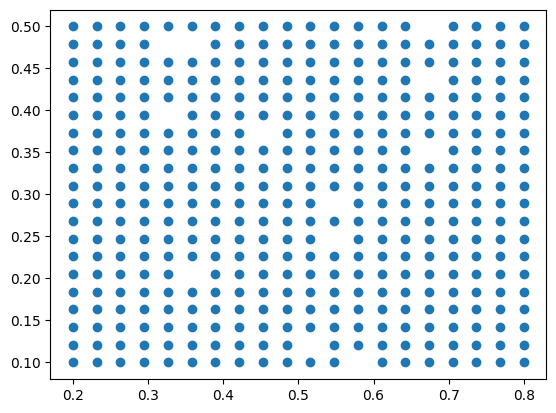

In [121]:
print(confidence_region)
x_points = [x[0] for x in confidence_region]
y_points = [x[1] for x in confidence_region]

print(x_points)
plt.plot(x_points, y_points, 'o')